In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
HEADERS = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=HEADERS)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=HEADERS)

test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
   lambda value: value.replace(".", "")
)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16281, 15)


In [3]:
train_data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
24276,21,Private,161415,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,<=50K
1241,55,Private,326297,HS-grad,9,Separated,Adm-clerical,Not-in-family,White,Female,0,0,25,United-States,<=50K
625,30,Private,124187,HS-grad,9,Never-married,Farming-fishing,Own-child,Black,Male,0,0,60,United-States,<=50K
20855,22,Private,190968,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,2407,0,40,United-States,<=50K
20611,27,Self-emp-not-inc,153546,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,0,0,40,United-States,<=50K
24115,18,Private,294387,11th,7,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
302,31,Private,217460,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States,>50K
18179,26,Private,152452,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,50,United-States,<=50K
31572,36,Private,418702,Assoc-voc,11,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
17916,44,Private,367749,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,45,Mexico,<=50K


In [4]:
train_data.replace(" ?", None, inplace=True)
test_data.replace(" ?", None, inplace=True)

In [5]:
def sort_none_last(xs):
    return sorted(xs, key=lambda x: (x is None, x))

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sort_none_last(list(train_data["workclass"].unique())),
    "education": sort_none_last(list(train_data["education"].unique())),
    "marital_status": sort_none_last(list(train_data["marital_status"].unique())),
    "occupation": sort_none_last(list(train_data["occupation"].unique())),
    "relationship": sort_none_last(list(train_data["relationship"].unique())),
    "race": sort_none_last(list(train_data["race"].unique())),
    "gender": sort_none_last(list(train_data["gender"].unique())),
    "native_country": sort_none_last(list(train_data["native_country"].unique())),
    "income_bracket": sort_none_last(list(train_data["income_bracket"].unique())),
}

In [6]:
def map_to_index(val, vocab):
    if val is None:
        return None
    return vocab.index(val)

for dataset in (train_data, test_data):
    for feature, vocab in CATEGORICAL_FEATURES_WITH_VOCABULARY.items():
        dataset[feature] = dataset[feature].map(lambda val: map_to_index(val, vocab))

In [7]:
train_data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
7372,26,3.0,276624,15,10,2,10.0,0,4,1,0,0,40,38.0,0
22838,58,1.0,53481,12,14,4,9.0,1,4,1,0,0,35,38.0,0
16549,35,3.0,112512,11,9,6,7.0,3,4,0,0,0,40,38.0,0
15536,21,3.0,129674,15,10,4,3.0,1,2,1,0,0,48,25.0,0
4528,28,5.0,33035,2,8,0,7.0,4,4,0,0,0,30,38.0,0
23337,23,3.0,267955,15,10,4,11.0,1,4,0,0,0,40,38.0,0
30425,36,3.0,108320,11,9,0,6.0,1,4,1,4101,0,40,38.0,0
9131,51,5.0,74160,12,14,0,9.0,4,4,1,0,0,60,38.0,1
5532,42,6.0,117583,10,16,0,9.0,1,4,0,8614,0,60,38.0,1
28536,38,4.0,140854,9,13,2,2.0,0,4,1,0,0,50,38.0,1


In [8]:
test_data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
15858,49,3.0,27614.0,11,9.0,5,6.0,1,4,0,0.0,0.0,40.0,38.0,0
11202,61,NaN,149855.0,5,4.0,2,NaN,0,4,1,0.0,2057.0,70.0,38.0,0
6869,26,1.0,176756.0,11,9.0,2,12.0,0,4,1,0.0,0.0,75.0,38.0,1
3751,46,3.0,171335.0,15,10.0,0,3.0,1,4,1,0.0,0.0,40.0,38.0,0
11590,50,3.0,178251.0,12,14.0,2,0.0,5,4,0,0.0,0.0,40.0,38.0,1
11507,28,3.0,202222.0,9,13.0,4,11.0,1,4,1,0.0,0.0,40.0,38.0,0
11691,49,3.0,220978.0,11,9.0,2,2.0,0,4,1,0.0,0.0,44.0,38.0,0
5610,25,1.0,187792.0,15,10.0,0,10.0,1,4,0,0.0,0.0,40.0,38.0,0
7429,37,3.0,215618.0,9,13.0,2,3.0,0,4,1,0.0,0.0,40.0,38.0,1
4598,47,NaN,127441.0,15,10.0,0,NaN,4,4,0,0.0,0.0,42.0,38.0,0


In [9]:
train_data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
gender               0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income_bracket       0
dtype: int64

In [10]:
train_data[train_data.duplicated() == True]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
4881,25,3.0,308144,9,13,4,2.0,1,4,1,0,0,40,25.0,0
5104,90,3.0,52386,15,10,4,7.0,1,1,1,0,0,35,38.0,0
9171,21,3.0,250051,15,10,4,9.0,3,4,0,0,0,10,38.0,0
11631,20,3.0,107658,15,10,4,12.0,1,4,0,0,0,10,38.0,0
13084,25,3.0,195994,3,2,4,8.0,1,4,0,0,0,40,12.0,0
15059,21,3.0,243368,13,1,4,4.0,1,4,1,0,0,50,25.0,0
17040,46,3.0,173243,11,9,2,2.0,0,4,1,0,0,40,38.0,0
18555,30,3.0,144593,11,9,4,7.0,1,2,1,0,0,40,NaN,0
18698,19,3.0,97261,11,9,4,4.0,1,4,1,0,0,40,38.0,0
21318,19,3.0,138153,15,10,4,0.0,3,4,0,0,0,10,38.0,0


In [11]:
train_data.drop_duplicates(inplace=True)

In [12]:
train_data.describe()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
count,32537.000000,30701.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,30694.000000,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000,31955.000000,32537.000000
mean,38.585549,3.100094,1.897808e+05,10.297507,10.081815,2.611427,5.967518,1.446538,3.665827,0.669238,1078.443741,87.368227,40.440329,36.390393,0.240926
std,13.637984,1.139938,1.055565e+05,3.870142,2.571633,1.506301,4.026549,1.607064,0.848847,0.470495,7387.957424,403.101833,12.346889,6.104904,0.427652
min,17.000000,0.000000,1.228500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,3.000000,1.178270e+05,9.000000,9.000000,2.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,38.000000,0.000000
50%,37.000000,3.000000,1.783560e+05,11.000000,10.000000,2.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,38.000000,0.000000
75%,48.000000,3.000000,2.369930e+05,12.000000,12.000000,4.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,38.000000,0.000000
max,90.000000,7.000000,1.484705e+06,15.000000,16.000000,6.000000,13.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,40.000000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

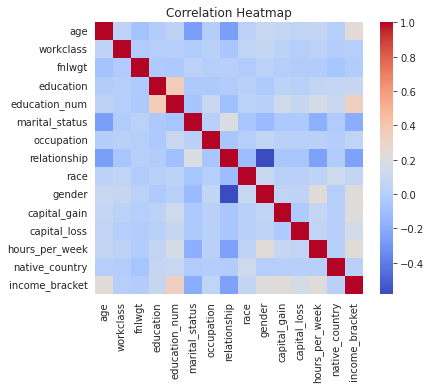

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(train_data.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')

In [14]:
counts = np.bincount(train_data["income_bracket"])
class_weight = {
    0: counts[0] / train_data.shape[0],
    1: counts[1] / train_data.shape[0]
}
scale_pos_weight = class_weight[0]/class_weight[1]
scale_pos_weight

3.1506569715524937

In [15]:
X_train = train_data.drop(columns=["income_bracket"], axis=1)
y_train = train_data["income_bracket"]
X_test = test_data.drop(columns=["income_bracket"], axis=1)
y_test = test_data["income_bracket"]

In [16]:
start = time.time()
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=350, learning_rate=0.13)
model = model.fit(X_train, y_train)

In [17]:
y_pred = model.predict(X_test.values)
print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
end = time.time()
print(f"Training time: {end - start}s")

F1 score: 0.7170317389360751
Accuracy: 0.8444812972176157
Training time: 5.498104572296143s
